In [209]:
#General libraries
import ast
import datetime
import pandas as pd
import numpy as np

#Visualization
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

#NlP
from tqdm import tqdm
import re
import string
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
import preprocessor as p #From "tweet-preprocessor library"

#Algorithms
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE

#Helper functions are in utils.py
from utils import drop_col, clean_txt, clean_time, convert_to_datetime, show_pie_val_pct

#Use seaborn style for plots
plt.style.use("seaborn")

In [2]:
#Show all rows
#pd.set_option("max_rows", None)

TODO:
- clean csvs
    - reorder the columns for all csvs
    - split date to different columns: year/ month/ day/ hour/ minute/ second
        - for review date
        - for response date
- add column for review origin store: google/apple
- add column for dev response time
- analysis on apple dataset: short analysis for us vs ca datasets
    - add flag for countries: apple_us, apple_ca
    - then combine both
    
- analysis
    - customer experience
        - does the dev respond to reviews?
        - how long does it take the devs to respond?
        - recurring praises: technical/ ux
        - recurring complaints: technical/ ux

In [3]:
df_google = pd.read_csv("../data/google_reviews.csv")
df_apple_us = pd.read_csv("../data/apple_reviews_us.csv")
df_apple_ca = pd.read_csv("../data/apple_reviews_ca.csv")

# (i) Data cleaning and manipulation

In [4]:
df_google.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt
0,gp:AOqpTOGlaNzM8c0Ch5u_tnuIsrlJJeCWufl9tn7YRL3...,Will Gage,https://play-lh.googleusercontent.com/-e5YakL9...,I love the design of this app. It is visually ...,3,0,1.2.1,2021-04-25 12:17:31,NaN,NaN
1,gp:AOqpTOFeK_8h1wm5Xz5qsGC8YSly0qzWkCRMpB3GCNl...,austin miller,https://play-lh.googleusercontent.com/a-/AOh14...,I sent one message and was informed that I had...,1,0,1.2.1,2021-04-24 03:24:38,NaN,NaN
2,gp:AOqpTOGZn93j19ujCZW8hOOQsaa4En8z1N1ibtTPk3g...,TheClassicnathan TCn,https://play-lh.googleusercontent.com/a-/AOh14...,"""Does this app make you happy?""",5,0,1.2.1,2021-04-23 22:05:12,NaN,NaN
3,gp:AOqpTOHluwlYpU9DdvPtMobyvesxzL-AEPUGn2JeSKP...,Jeremie Mazerolle,https://play-lh.googleusercontent.com/a-/AOh14...,"Ok, the concept of this app is awesome, but is...",3,0,1.2.1,2021-04-23 04:46:57,NaN,NaN
4,gp:AOqpTOFGS5qauNo9BDUKxU6eQS7bTzdEg4QoeTldD5O...,Robert M,https://play-lh.googleusercontent.com/a-/AOh14...,Can't even try the app. Requires to validate w...,1,0,NaN,2021-04-23 02:24:40,NaN,NaN


In [5]:
df_apple_us.head()

,date,userName,isEdited,title,review,rating,developerResponse
0,2020-10-28 03:15:26,blooolp,False,Cool but empty,"I assume its just cause its new, it has great ...",4,NaN
1,2021-02-25 03:54:12,Antmo01,False,Some of my thoughts,"First off, I just wanna say that this is app i...",2,NaN
2,2020-11-05 07:41:17,jj_2077,False,"Cool concept, but poor execution and empty app","Conceptually, this is a very interesting way t...",3,NaN
3,2020-10-05 19:11:24,SoundsLikeALottaHOOPLAH,False,"A good app, but not very useful",While the idea of the app is excellent in conc...,3,NaN
4,2020-06-29 15:05:11,Xandaroth,False,Finally a legit app for gamers!?,After being burned out on all the dating apps ...,5,NaN


In [6]:
df_apple_ca.head()

,review,rating,userName,date,title,isEdited
0,Game icons don’t show when I try to add them,3,CrazyChestnut,2019-08-25 02:40:23,Bug?,False
1,Hey! There’s a bug that doesn’t allow iPhone u...,3,jesuisxiv,2021-04-01 01:37:18,Photo Card Bug,False
2,Lack of users app has to be reset a lot,1,Anthony12673454,2021-04-05 16:47:24,Lacking,False
3,"The app works alright, and has acceptable func...",3,POTATOeTREE,2020-06-24 15:46:16,"Ok, but no people.",False
4,Would really like to see this grow. But for no...,1,Xetreon,2021-03-25 12:32:47,"Good concept, no people, dead app",False


In [7]:
df_google.columns

Index(['reviewId', 'userName', 'userImage', 'content', 'score',
       'thumbsUpCount', 'reviewCreatedVersion', 'at', 'replyContent',
       'repliedAt'],
      dtype='object')

In [8]:
df_apple_us.columns

Index(['date', 'userName', 'isEdited', 'title', 'review', 'rating',
       'developerResponse'],
      dtype='object')

## Apple Reviews

### Dropping unwanted columns

In [9]:
#def drop_col(df, cols):
#    df.drop(cols, axis=1, inplace=True)

In [10]:
apple_col_names_to_drop = ["userName"]

In [11]:
drop_col(df_apple_us, apple_col_names_to_drop)

In [12]:
drop_col(df_apple_ca, apple_col_names_to_drop)

In [13]:
df_apple_us.head()

,date,isEdited,title,review,rating,developerResponse
0,2020-10-28 03:15:26,False,Cool but empty,"I assume its just cause its new, it has great ...",4,NaN
1,2021-02-25 03:54:12,False,Some of my thoughts,"First off, I just wanna say that this is app i...",2,NaN
2,2020-11-05 07:41:17,False,"Cool concept, but poor execution and empty app","Conceptually, this is a very interesting way t...",3,NaN
3,2020-10-05 19:11:24,False,"A good app, but not very useful",While the idea of the app is excellent in conc...,3,NaN
4,2020-06-29 15:05:11,False,Finally a legit app for gamers!?,After being burned out on all the dating apps ...,5,NaN


In [14]:
df_apple_ca.head()

,review,rating,date,title,isEdited
0,Game icons don’t show when I try to add them,3,2019-08-25 02:40:23,Bug?,False
1,Hey! There’s a bug that doesn’t allow iPhone u...,3,2021-04-01 01:37:18,Photo Card Bug,False
2,Lack of users app has to be reset a lot,1,2021-04-05 16:47:24,Lacking,False
3,"The app works alright, and has acceptable func...",3,2020-06-24 15:46:16,"Ok, but no people.",False
4,Would really like to see this grow. But for no...,1,2021-03-25 12:32:47,"Good concept, no people, dead app",False


In [15]:
print("apple:", "\nca:",df_apple_ca.shape, "\nus:",df_apple_us.shape)

apple: 
ca: (25, 5) 
us: (266, 6)


### Extracting input values to proper columns - "developerResponse"

In [16]:
#How many nan in df_apple_us
df_apple_us["developerResponse"].isnull().sum()

211

In [17]:
#Show all responses that aren't nan for df_apple_us
apple_us_dev_res= pd.notnull(df_apple_us["developerResponse"])
df_apple_us[apple_us_dev_res]

,date,isEdited,title,review,rating,developerResponse
5,2020-03-12 09:00:55,False,Cool App!,"This app is so unique, i’ve never seen anythin...",4,"{'id': 14873083, 'body': 'Hello!\n\nThank you ..."
9,2019-11-15 03:59:48,True,Great App,[EDIT at bottom]\nI love the style and design ...,5,"{'id': 11831767, 'body': 'Hello! Thanks so muc..."
14,2020-06-18 03:41:33,False,Can’t do a lot,I don’t know if it’s because of screen scaling...,3,"{'id': 16261816, 'body': 'Hello,\n\nThanks for..."
18,2020-05-04 08:11:16,False,its interesting but.. 🥺,This app is pretty interesting. I like how you...,3,"{'id': 15199514, 'body': 'Hello!\n\nThank you ..."
29,2019-09-20 16:36:53,False,First Impressions,"So far, I love the app and the concept! It def...",3,"{'id': 10828984, 'body': 'Hello! We are so gla..."
30,2019-08-21 21:53:09,False,It’s Mediocre,"Although a fun and quirky app to begin with, a...",1,"{'id': 10673400, 'body': ""Hello!\n\nThank you ..."
36,2020-03-31 00:03:30,False,Great Idea! But,I love this app and the idea behind it to brin...,3,"{'id': 14872893, 'body': 'Hello!\n\nThank you ..."
40,2020-05-07 16:01:54,False,Its pretty good,I was pretty surprised by the app. Although th...,4,"{'id': 15199440, 'body': 'Hey!\n\nThanks so mu..."
47,2020-11-09 09:18:02,True,"I may reconsider at a later time, a rather dea...","I may come back to this app, it’s just not for...",2,"{'id': 14928856, 'body': 'Hello!\n\nthanks so ..."
50,2020-08-02 10:33:18,False,Deleted conversations,So I recently joined this app to see what is o...,1,"{'id': 17045920, 'body': 'Hey! We had a bug wi..."


In [18]:
#Example of "developerResponse" structure
df_apple_us["developerResponse"][5]

"{'id': 14873083, 'body': 'Hello!\\n\\nThank you so much for taking the time to leave us a review! We are so glad that you are enjoying using Kippo! We are working on adding advanced filters so you can find people based off things like console and game title. This is all great feedback and we would love to hear more. Please feel free to send us feedback or ideas anytime at sup@kippoapp.com. Please let us know if there is anything else that we can do to make Kippo a 5 star experience for you!\\n\\nBest,\\nKippo Team', 'modified': '2020-04-23T21:25:56Z'}"

In [19]:
#"developerResponse" has a dict like structure, so we need to extract them accordingly
apple_us_dev_res = df_apple_us[apple_us_dev_res]["developerResponse"].apply(lambda x: ast.literal_eval(x))

In [20]:
apple_us_dev_res = apple_us_dev_res.apply(pd.Series)

In [21]:
apple_us_dev_res

,id,body,modified
5,14873083,Hello!\n\nThank you so much for taking the tim...,2020-04-23T21:25:56Z
9,11831767,Hello! Thanks so much for being part of our co...,2019-11-14T00:25:38Z
14,16261816,"Hello,\n\nThanks for your feedback. Kippo is c...",2020-06-28T09:51:25Z
18,15199514,Hello!\n\nThank you for taking the time to lea...,2020-05-08T21:14:18Z
29,10828984,Hello! We are so glad that you love the app bu...,2019-09-23T06:42:04Z
30,10673400,Hello!\n\nThank you so much for being an early...,2019-09-13T21:55:16Z
36,14872893,Hello!\n\nThank you so much for taking the tim...,2020-04-23T21:10:07Z
40,15199440,Hey!\n\nThanks so much for taking the time to ...,2020-05-08T21:08:39Z
47,14928856,Hello!\n\nthanks so much for taking the time t...,2020-04-27T06:09:19Z
50,17045920,Hey! We had a bug with the new update that mad...,2020-08-03T10:46:13Z


In [22]:
#Merge apple_us_dev_res back to the original df_apple_us 
df_apple_us = pd.concat([df_apple_us, apple_us_dev_res], axis=1)

In [23]:
df_apple_us.head()

,date,isEdited,title,review,rating,developerResponse,id,body,modified
0,2020-10-28 03:15:26,False,Cool but empty,"I assume its just cause its new, it has great ...",4,NaN,NaN,NaN,NaN
1,2021-02-25 03:54:12,False,Some of my thoughts,"First off, I just wanna say that this is app i...",2,NaN,NaN,NaN,NaN
2,2020-11-05 07:41:17,False,"Cool concept, but poor execution and empty app","Conceptually, this is a very interesting way t...",3,NaN,NaN,NaN,NaN
3,2020-10-05 19:11:24,False,"A good app, but not very useful",While the idea of the app is excellent in conc...,3,NaN,NaN,NaN,NaN
4,2020-06-29 15:05:11,False,Finally a legit app for gamers!?,After being burned out on all the dating apps ...,5,NaN,NaN,NaN,NaN


In [24]:
#Drop old "developerResponse" and assign "body" as the new "developerResponse"
drop_col(df_apple_us, ["developerResponse", "id"])

In [25]:
df_apple_us.rename(columns={
    "date":"revPostDate",
    "body":"devResponse",
    "modified":"devResponseDate"
}, inplace=True)

In [26]:
#Adding store and country flags
df_apple_us["store"] = "Apple"
df_apple_us["country"] = "USA"

In [27]:
df_apple_ca["store"] = "Apple"
df_apple_ca["country"] = "Canada"

In [28]:
df_apple_ca.rename(columns={"date":"revPostDate"}, inplace=True)

### Merging both apple dataframes

In [29]:
#Join both apple dataframes
df_apple = pd.concat([df_apple_us, df_apple_ca], axis=0)

In [30]:
df_apple = df_apple.reset_index(drop=True)

In [31]:
df_apple["continent"] = "NA"

In [32]:
df_apple.head()

,revPostDate,isEdited,title,review,rating,devResponse,devResponseDate,store,country,continent
0,2020-10-28 03:15:26,False,Cool but empty,"I assume its just cause its new, it has great ...",4,NaN,NaN,Apple,USA,NA
1,2021-02-25 03:54:12,False,Some of my thoughts,"First off, I just wanna say that this is app i...",2,NaN,NaN,Apple,USA,NA
2,2020-11-05 07:41:17,False,"Cool concept, but poor execution and empty app","Conceptually, this is a very interesting way t...",3,NaN,NaN,Apple,USA,NA
3,2020-10-05 19:11:24,False,"A good app, but not very useful",While the idea of the app is excellent in conc...,3,NaN,NaN,Apple,USA,NA
4,2020-06-29 15:05:11,False,Finally a legit app for gamers!?,After being burned out on all the dating apps ...,5,NaN,NaN,Apple,USA,NA


In [33]:
df_apple.shape

(291, 10)

### Clean from "review" and "devResponse" from \n

In [34]:
#def clean_txt(df, col):
#    df[col].replace(r"\s+|\\n", " ", regex=True, inplace=True)

In [35]:
clean_txt(df_apple, "review")
clean_txt(df_apple, "devResponse")

In [36]:
dev_response_date = df_apple["devResponseDate"].notnull()
df_apple[dev_response_date]

,revPostDate,isEdited,title,review,rating,devResponse,devResponseDate,store,country,continent
5,2020-03-12 09:00:55,False,Cool App!,"This app is so unique, i’ve never seen anythin...",4,Hello! Thank you so much for taking the time t...,2020-04-23T21:25:56Z,Apple,USA,NA
9,2019-11-15 03:59:48,True,Great App,[EDIT at bottom] I love the style and design o...,5,Hello! Thanks so much for being part of our co...,2019-11-14T00:25:38Z,Apple,USA,NA
14,2020-06-18 03:41:33,False,Can’t do a lot,I don’t know if it’s because of screen scaling...,3,"Hello, Thanks for your feedback. Kippo is comp...",2020-06-28T09:51:25Z,Apple,USA,NA
18,2020-05-04 08:11:16,False,its interesting but.. 🥺,This app is pretty interesting. I like how you...,3,Hello! Thank you for taking the time to leave ...,2020-05-08T21:14:18Z,Apple,USA,NA
29,2019-09-20 16:36:53,False,First Impressions,"So far, I love the app and the concept! It def...",3,Hello! We are so glad that you love the app bu...,2019-09-23T06:42:04Z,Apple,USA,NA
30,2019-08-21 21:53:09,False,It’s Mediocre,"Although a fun and quirky app to begin with, a...",1,Hello! Thank you so much for being an early us...,2019-09-13T21:55:16Z,Apple,USA,NA
36,2020-03-31 00:03:30,False,Great Idea! But,I love this app and the idea behind it to brin...,3,Hello! Thank you so much for taking the time t...,2020-04-23T21:10:07Z,Apple,USA,NA
40,2020-05-07 16:01:54,False,Its pretty good,I was pretty surprised by the app. Although th...,4,Hey! Thanks so much for taking the time to wri...,2020-05-08T21:08:39Z,Apple,USA,NA
47,2020-11-09 09:18:02,True,"I may reconsider at a later time, a rather dea...","I may come back to this app, it’s just not for...",2,Hello! thanks so much for taking the time to l...,2020-04-27T06:09:19Z,Apple,USA,NA
50,2020-08-02 10:33:18,False,Deleted conversations,So I recently joined this app to see what is o...,1,Hey! We had a bug with the new update that mad...,2020-08-03T10:46:13Z,Apple,USA,NA


### Clean "devResponseDate" from "T" and "Z"

In [37]:
clean_time(df_apple, "devResponseDate")

### Convert columns to datetime

In [38]:
convert_to_datetime(df_apple, "revPostDate")
convert_to_datetime(df_apple, "devResponseDate")

### Calculate the response time of the developers

In [39]:
df_apple["durationUntilDevResponse"] = df_apple["revPostDate"] - df_apple["devResponseDate"]

In [40]:
df_apple[df_apple["durationUntilDevResponse"].notna()]

,revPostDate,isEdited,title,review,rating,devResponse,devResponseDate,store,country,continent,durationUntilDevResponse
5,2020-03-12 09:00:55,False,Cool App!,"This app is so unique, i’ve never seen anythin...",4,Hello! Thank you so much for taking the time t...,2020-04-23 21:25:56,Apple,USA,NA,-43 days +11:34:59
9,2019-11-15 03:59:48,True,Great App,[EDIT at bottom] I love the style and design o...,5,Hello! Thanks so much for being part of our co...,2019-11-14 00:25:38,Apple,USA,NA,1 days 03:34:10
14,2020-06-18 03:41:33,False,Can’t do a lot,I don’t know if it’s because of screen scaling...,3,"Hello, Thanks for your feedback. Kippo is comp...",2020-06-28 09:51:25,Apple,USA,NA,-11 days +17:50:08
18,2020-05-04 08:11:16,False,its interesting but.. 🥺,This app is pretty interesting. I like how you...,3,Hello! Thank you for taking the time to leave ...,2020-05-08 21:14:18,Apple,USA,NA,-5 days +10:56:58
29,2019-09-20 16:36:53,False,First Impressions,"So far, I love the app and the concept! It def...",3,Hello! We are so glad that you love the app bu...,2019-09-23 06:42:04,Apple,USA,NA,-3 days +09:54:49
30,2019-08-21 21:53:09,False,It’s Mediocre,"Although a fun and quirky app to begin with, a...",1,Hello! Thank you so much for being an early us...,2019-09-13 21:55:16,Apple,USA,NA,-24 days +23:57:53
36,2020-03-31 00:03:30,False,Great Idea! But,I love this app and the idea behind it to brin...,3,Hello! Thank you so much for taking the time t...,2020-04-23 21:10:07,Apple,USA,NA,-24 days +02:53:23
40,2020-05-07 16:01:54,False,Its pretty good,I was pretty surprised by the app. Although th...,4,Hey! Thanks so much for taking the time to wri...,2020-05-08 21:08:39,Apple,USA,NA,-2 days +18:53:15
47,2020-11-09 09:18:02,True,"I may reconsider at a later time, a rather dea...","I may come back to this app, it’s just not for...",2,Hello! thanks so much for taking the time to l...,2020-04-27 06:09:19,Apple,USA,NA,196 days 03:08:43
50,2020-08-02 10:33:18,False,Deleted conversations,So I recently joined this app to see what is o...,1,Hey! We had a bug with the new update that mad...,2020-08-03 10:46:13,Apple,USA,NA,-2 days +23:47:05


There are a few **positive values** in "durationUntilDevResponse", which **means that the post has been updated by the user after the devs response**.

In [41]:
#Check user reviews that had been edited
df_apple[df_apple["revPostDate"] > df_apple["devResponseDate"]]

,revPostDate,isEdited,title,review,rating,devResponse,devResponseDate,store,country,continent,durationUntilDevResponse
9,2019-11-15 03:59:48,True,Great App,[EDIT at bottom] I love the style and design o...,5,Hello! Thanks so much for being part of our co...,2019-11-14 00:25:38,Apple,USA,NA,1 days 03:34:10
47,2020-11-09 09:18:02,True,"I may reconsider at a later time, a rather dea...","I may come back to this app, it’s just not for...",2,Hello! thanks so much for taking the time to l...,2020-04-27 06:09:19,Apple,USA,NA,196 days 03:08:43
114,2020-08-04 13:11:41,True,Friends,I truly enjoy this app. I know it’s supposed t...,4,Hey! We had a bug with the new update that mad...,2020-08-03 10:46:01,Apple,USA,NA,1 days 02:25:40
210,2020-01-24 09:34:13,True,Nevermind,"Rly good app, better than Tinder. Just needs m...",1,Thanks so much for you 5star review and thanks...,2019-12-09 03:38:41,Apple,USA,NA,46 days 05:55:32


## Google Reviews

In [42]:
df_apple["durationUntilDevResponse"].notnull().sum()

55

In [43]:
df_google["store"] = "Google"
df_google["continent"] = "NA"

In [44]:
google_col_names_list = {
    "content": "review",
    "score": "rating",
    "at": "revPostDate",
    "replyContent": "devResponse",
    "repliedAt": "devResponseDate"
}

In [45]:
df_google.rename(columns=google_col_names_list, inplace=True)

### Dropping unwanted columns

In [46]:
google_col_names_to_drop = ["reviewId", "userName", "userImage"]

In [47]:
drop_col(df_google, google_col_names_to_drop)

In [48]:
df_google.head()

,review,rating,thumbsUpCount,reviewCreatedVersion,revPostDate,devResponse,devResponseDate,store,continent
0,I love the design of this app. It is visually ...,3,0,1.2.1,2021-04-25 12:17:31,NaN,NaN,Google,NA
1,I sent one message and was informed that I had...,1,0,1.2.1,2021-04-24 03:24:38,NaN,NaN,Google,NA
2,"""Does this app make you happy?""",5,0,1.2.1,2021-04-23 22:05:12,NaN,NaN,Google,NA
3,"Ok, the concept of this app is awesome, but is...",3,0,1.2.1,2021-04-23 04:46:57,NaN,NaN,Google,NA
4,Can't even try the app. Requires to validate w...,1,0,NaN,2021-04-23 02:24:40,NaN,NaN,Google,NA


In [49]:
print("google:",df_google.shape)

google: (617, 9)


### Convert columns to datetime

In [50]:
convert_to_datetime(df_google, "revPostDate")
convert_to_datetime(df_google, "devResponseDate")

### Calculate the response time of the developers

In [51]:
df_google["durationUntilDevResponse"] = df_google["revPostDate"] - df_google["devResponseDate"]
df_google[df_google["durationUntilDevResponse"].notnull()]

,review,rating,thumbsUpCount,reviewCreatedVersion,revPostDate,devResponse,devResponseDate,store,continent,durationUntilDevResponse
141,"There's a bug out there with ""please check you...",3,2,NaN,2021-02-21 20:06:08,Hey! These are some great ideas! Kippo is stil...,2020-12-04 22:13:53,Google,NA,78 days 21:52:15
185,"Love the idea and the UI of this app, even if ...",4,6,1.2.1,2021-02-05 14:13:13,"Hello, we've fixed it. Thanks for reporting :)",2021-02-05 03:44:02,Google,NA,0 days 10:29:11
474,I don't know why my review was removed but her...,1,1,1.0.23,2020-12-04 23:35:33,Hey! Thanks so much for your feedback. We've u...,2020-12-04 22:20:33,Google,NA,0 days 01:15:00
476,Good works great.,5,1,1.0.17,2020-12-04 20:27:10,Hey Audrey! Thanks so much for your 5 star rev...,2020-12-04 22:06:42,Google,NA,-1 days +22:20:28
477,I waited forever for this on Android and its b...,5,0,1.0.18,2020-12-04 16:20:42,Hey Timothy! Thanks so much for your 5 star re...,2020-12-04 22:07:35,Google,NA,-1 days +18:13:07
478,The fact I couldn't just used my email was a p...,1,1,NaN,2020-12-04 05:51:07,Hey Joe! I completely understand why you would...,2020-12-04 22:09:44,Google,NA,-1 days +07:41:23
479,Excellent app thanks,5,1,1.0.17,2020-12-04 04:21:59,Hey Bryce! Thanks so much for your 5 star revi...,2020-12-04 22:10:18,Google,NA,-1 days +06:11:41
480,It's a great Idea but it could be so much more...,3,1,1.0.23,2020-12-04 00:28:31,Hey Krissy! Thanks for your feedback! We're st...,2020-12-04 22:11:21,Google,NA,-1 days +02:17:10
481,Well I like the concept but I dont like this a...,3,3,1.0.23,2020-12-03 17:00:12,Hey! Thank you for trying Kippo. We don't show...,2020-12-04 22:15:49,Google,NA,-2 days +18:44:23
483,"Love it, I’ll challenge anyone to Overcooked o...",5,0,1.0.17,2020-12-03 13:47:41,Haha! I'll take you up on that challenge. Than...,2020-12-04 22:18:56,Google,NA,-2 days +15:28:45


Like the "df_apple", there are also **positive values** in the "durationUntilDevResponse" column, which **means that the post has been updated by the user after the devs response**.

In [52]:
#Check user reviews that had been edited
df_google[df_google["revPostDate"] > df_google["devResponseDate"]]

,review,rating,thumbsUpCount,reviewCreatedVersion,revPostDate,devResponse,devResponseDate,store,continent,durationUntilDevResponse
141,"There's a bug out there with ""please check you...",3,2,NaN,2021-02-21 20:06:08,Hey! These are some great ideas! Kippo is stil...,2020-12-04 22:13:53,Google,NA,78 days 21:52:15
185,"Love the idea and the UI of this app, even if ...",4,6,1.2.1,2021-02-05 14:13:13,"Hello, we've fixed it. Thanks for reporting :)",2021-02-05 03:44:02,Google,NA,0 days 10:29:11
474,I don't know why my review was removed but her...,1,1,1.0.23,2020-12-04 23:35:33,Hey! Thanks so much for your feedback. We've u...,2020-12-04 22:20:33,Google,NA,0 days 01:15:00
485,I am currently paying for the premium and some...,2,18,1.0.23,2020-12-03 03:34:38,Hey Hayden. We wanted to give sort of a daily ...,2020-10-15 03:57:27,Google,NA,48 days 23:37:11
522,"Edit: Changed rating to 4 stars, update has be...",4,8,1.0.18,2020-11-09 07:58:47,"Hey Joel. Have you checked out the ""text promp...",2020-10-15 03:58:41,Google,NA,25 days 04:00:06
600,Would be much better if your 30 likes are only...,4,0,1.0.3,2020-10-01 00:03:05,Hey! Thanks so much for taking the time to lea...,2020-09-23 04:51:20,Google,NA,7 days 19:11:45
604,"Decided to try the app again, and it seems to ...",3,0,1.0.1,2020-09-24 01:57:50,Hey! Please send us an email at sup@kippoapp.c...,2020-09-23 04:50:28,Google,NA,0 days 21:07:22
606,"Been waiting a while for this, and it delivers...",4,16,1.0.1,2020-09-23 05:01:43,Thanks so much for taking the time to leave us...,2020-09-23 04:58:58,Google,NA,0 days 00:02:45
607,I've been using this for a few days and am a p...,3,4,1.0.1,2020-09-23 04:53:39,Hey! Thanks so much for taking the time to lea...,2020-09-23 04:48:28,Google,NA,0 days 00:05:11


## Join Apple and Google reviews

In [53]:
df_total_rev = pd.concat([df_apple, df_google], axis=0)

In [54]:
df_total_rev.to_csv("../data/total_reviews.csv", index=False)

# (ii) Visualization

In [55]:
df_main = df_total_rev.copy()

In [56]:
df_main.head()

,revPostDate,isEdited,title,review,rating,devResponse,devResponseDate,store,country,continent,durationUntilDevResponse,thumbsUpCount,reviewCreatedVersion
0,2020-10-28 03:15:26,False,Cool but empty,"I assume its just cause its new, it has great ...",4,NaN,NaT,Apple,USA,NA,NaT,NaN,NaN
1,2021-02-25 03:54:12,False,Some of my thoughts,"First off, I just wanna say that this is app i...",2,NaN,NaT,Apple,USA,NA,NaT,NaN,NaN
2,2020-11-05 07:41:17,False,"Cool concept, but poor execution and empty app","Conceptually, this is a very interesting way t...",3,NaN,NaT,Apple,USA,NA,NaT,NaN,NaN
3,2020-10-05 19:11:24,False,"A good app, but not very useful",While the idea of the app is excellent in conc...,3,NaN,NaT,Apple,USA,NA,NaT,NaN,NaN
4,2020-06-29 15:05:11,False,Finally a legit app for gamers!?,After being burned out on all the dating apps ...,5,NaN,NaT,Apple,USA,NA,NaT,NaN,NaN


In [57]:
#Sort df by the date of review post
df_main.sort_values("revPostDate", ascending=False, ignore_index=True, inplace=True)

In [58]:
#Check for possible duplicates
df_main.duplicated().isna().sum()

0

### How lond did it take the dev to respond?

"durationUntilDevResponse" is difference between the review date and the time it took for the dev to respond. Thus, the result is a negative time delta. If, the review has been edited after the dev has repondend, then the time delta will be positive.
When this happens, the review date is updated. Thus, we lose the original review date.

In [59]:
#Get only the negative time deltas for "durationUntilDevResponse"
dev_response_time = df_main[df_main["revPostDate"] < df_main["devResponseDate"]]
dev_response_time

,revPostDate,isEdited,title,review,rating,devResponse,devResponseDate,store,country,continent,durationUntilDevResponse,thumbsUpCount,reviewCreatedVersion
549,2020-12-04 20:27:10,NaN,NaN,Good works great.,5,Hey Audrey! Thanks so much for your 5 star rev...,2020-12-04 22:06:42,Google,NaN,NA,-1 days +22:20:28,1.0,1.0.17
550,2020-12-04 16:20:42,NaN,NaN,I waited forever for this on Android and its b...,5,Hey Timothy! Thanks so much for your 5 star re...,2020-12-04 22:07:35,Google,NaN,NA,-1 days +18:13:07,0.0,1.0.18
551,2020-12-04 05:51:07,NaN,NaN,The fact I couldn't just used my email was a p...,1,Hey Joe! I completely understand why you would...,2020-12-04 22:09:44,Google,NaN,NA,-1 days +07:41:23,1.0,NaN
552,2020-12-04 04:21:59,NaN,NaN,Excellent app thanks,5,Hey Bryce! Thanks so much for your 5 star revi...,2020-12-04 22:10:18,Google,NaN,NA,-1 days +06:11:41,1.0,1.0.17
553,2020-12-04 00:28:31,NaN,NaN,It's a great Idea but it could be so much more...,3,Hey Krissy! Thanks for your feedback! We're st...,2020-12-04 22:11:21,Google,NaN,NA,-1 days +02:17:10,1.0,1.0.23
...,...,...,...,...,...,...,...,...,...,...,...,...,...
891,2019-09-07 04:39:37,False,The app I’ve been looking for,I have been wanting to find friends to game wi...,5,Hey! Thanks so much for being an early user! W...,2019-09-13 22:00:07,Apple,USA,NA,-7 days +06:39:30,NaN,NaN
894,2019-08-29 19:43:49,False,Trash app,To start some of the profiles have fake indivi...,1,"Hello, We make sure to verify all of our profi...",2019-09-13 21:27:42,Apple,USA,NA,-16 days +22:16:07,NaN,NaN
896,2019-08-21 21:53:09,False,It’s Mediocre,"Although a fun and quirky app to begin with, a...",1,Hello! Thank you so much for being an early us...,2019-09-13 21:55:16,Apple,USA,NA,-24 days +23:57:53,NaN,NaN
900,2019-08-16 22:28:17,False,The interface is so smooth,Its an app that brings people from the gaming ...,4,Hello! Thank you so much for a being one of ou...,2019-09-13 21:57:39,Apple,USA,NA,-28 days +00:30:38,NaN,NaN


**Note:** First, we'll be converting the time deltas to seconds, because a straight conversion would round the values. Then, we calculate the seconds to minutes and from there to hours

In [60]:
#How many seconds
time_delta_s =  -(pd.to_timedelta(dev_response_time["durationUntilDevResponse"])).astype('timedelta64[s]')

In [61]:
time_delta_s

549       5972.0
550      20813.0
551      58717.0
552      64099.0
553      78170.0
         ...    
891     580830.0
894    1302233.0
896    1987327.0
900    2417362.0
901    2417678.0
Name: durationUntilDevResponse, Length: 96, dtype: float64

In [62]:
#Hours
time_delta_h = (time_delta_s/60/60)
time_delta_h

549      1.658889
550      5.781389
551     16.310278
552     17.805278
553     21.713889
          ...    
891    161.341667
894    361.731389
896    552.035278
900    671.489444
901    671.577222
Name: durationUntilDevResponse, Length: 96, dtype: float64

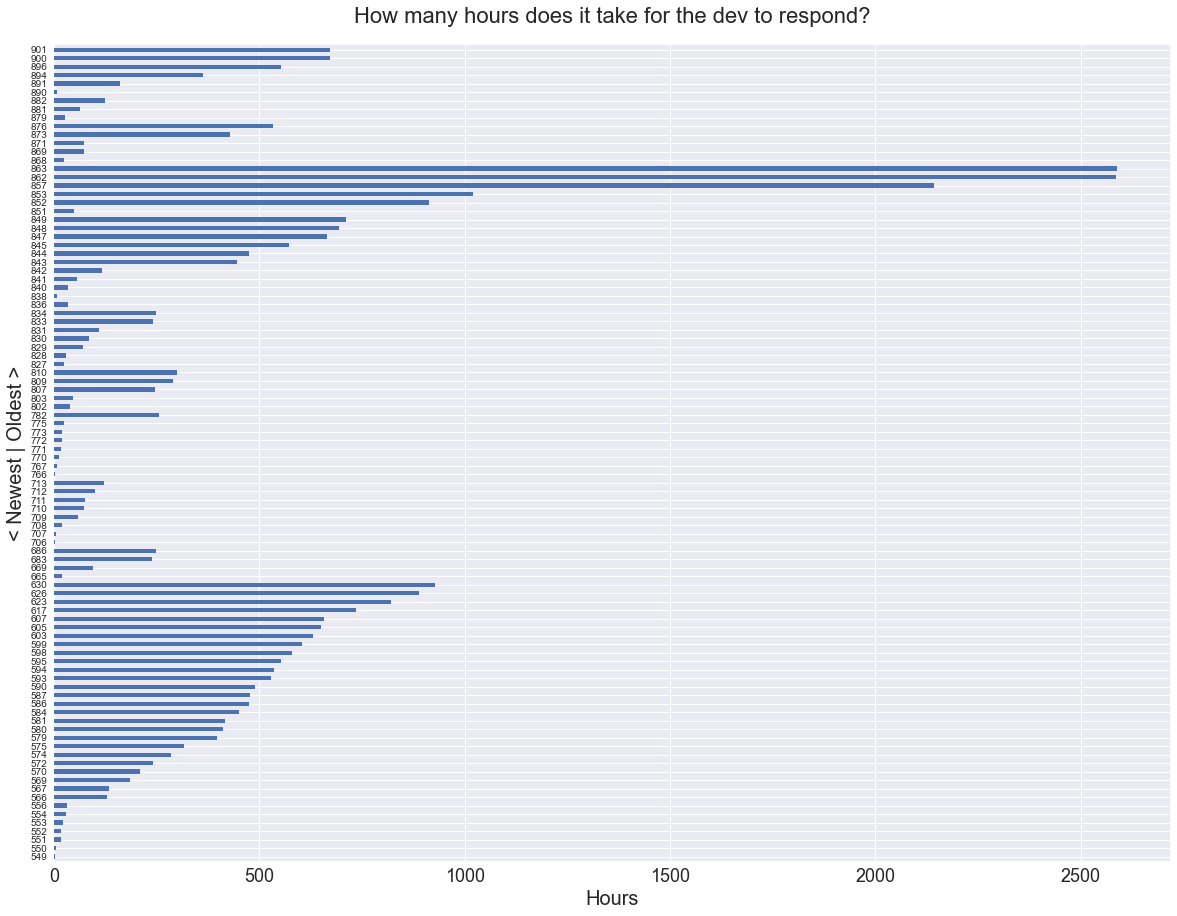

In [63]:
time_delta_h.plot(kind="barh", figsize=(20, 15))
ax = plt.gca()
ax.tick_params(axis="x", labelsize=18)
ax.tick_params(axis="y", labelsize=10)
plt.title("How many hours does it take for the dev to respond?", fontsize=22, y=1.02)
plt.ylabel("< Newest | Oldest >", fontsize=20)
plt.xlabel("Hours", fontsize=20)
plt.show()

**Insight**
- As time progresses, it seems that they are reducing they're overall response time

### Overall, how much customer interaction does the app have?

In [64]:
#def show_pie_val_pct(pct, total_n):
#    absolute = int(np.round(pct/100.*np.sum(total_n)))
#    return "{:.1f}%\nN={}".format(pct, absolute)

In [65]:
total_len = len(df_main)
total_no_res = df_main["durationUntilDevResponse"].isnull().sum()

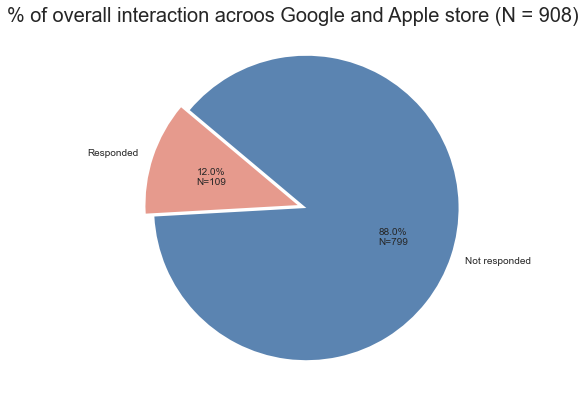

In [66]:
fig1, ax1 = plt.subplots(figsize=(10, 7))
fig1.suptitle("% of overall interaction acroos Google and Apple store (N = {})".format(total_len), fontsize=20, y=0.9)

labels = "Responded", "Not responded"
colors = ["#e69a8d", "#5b84b1"]
sizes = [(total_len-total_no_res)/total_len, total_no_res/total_len]#["Responded", "Not responded"]
explode = (0.03, 0.03)

ax1.pie(sizes, colors=colors, labels=labels, explode=explode, autopct=lambda pct: show_pie_val_pct(pct, total_len), startangle=140)
plt.show()

### How much interaction on Apple store?

In [67]:
df_apple_no_res = df_apple["devResponseDate"].isnull().sum()
df_apple_total = len(df_apple)

df_google_no_res = df_google["devResponseDate"].isnull().sum()
df_google_total = len(df_google)

df_apple_no_res / df_apple_total *100

81.09965635738831

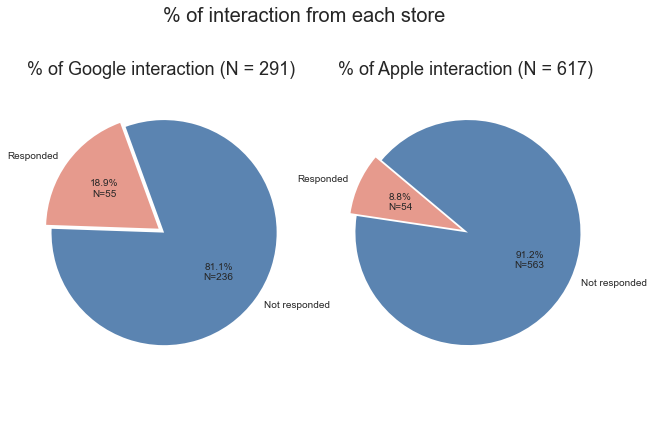

In [68]:
fig2, (ax1, ax2) = plt.subplots(figsize=(10, 7), nrows=1, ncols=2)
fig2.suptitle("% of interaction from each store", fontsize=20, y= 0.95)

sizes_apple = [(df_apple_total - df_apple_no_res)/df_apple_total, df_apple_no_res/df_apple_total]#["Responded", "Not responded"]
sizes_google = [(df_google_total - df_google_no_res)/df_google_total, df_google_no_res/df_google_total]#["Responded", "Not responded"]

ax1.pie(sizes_apple, labels=labels, colors=colors, explode=explode, startangle=110, 
        autopct=lambda pct: show_pie_val_pct(pct, df_apple_total))
ax1.set_title("% of Google interaction (N = {})".format(df_apple_total), fontsize=18, y=0.9)
ax1.axis("equal")

ax2.pie(sizes_google, labels=labels, colors=colors, explode=explode, startangle=140,
        autopct=lambda pct: show_pie_val_pct(pct, df_google_total))
ax2.set_title("% of Apple interaction (N = {})".format(df_google_total), fontsize=18, y=0.9)
ax2.axis("equal")

plt.show()

### Overall rating

In [69]:
rating_1 = ((df_main["rating"]==1).sum()) / len(df_main)
rating_2 = ((df_main["rating"]==2).sum()) / len(df_main)
rating_3 = ((df_main["rating"]==3).sum()) / len(df_main)
rating_4 = ((df_main["rating"]==4).sum()) / len(df_main)
rating_5 = ((df_main["rating"]==5).sum()) / len(df_main)

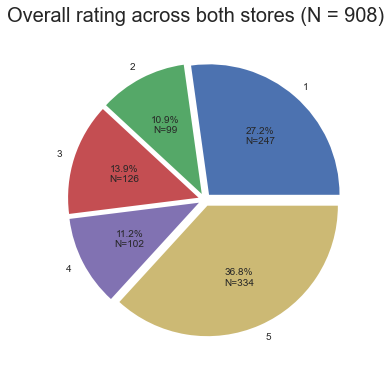

In [70]:
fig, ax = plt.subplots(figsize=(10, 6), nrows=1, ncols=1)
plt.suptitle("Overall rating across both stores (N = {})".format(len(df_main)), fontsize=20, y=0.95)
labels = ["1", "2", "3", "4", "5"]
rating_sizes = [rating_1, rating_2, rating_3, rating_4, rating_5]

ax.pie(rating_sizes, labels=labels, explode=[0.05]*5, autopct=lambda pct: show_pie_val_pct(pct, len(df_main)))
plt.show()

# (iii) Feature engineering

Adding word count for "reviewWordCount"

In [71]:
df_main["reviewWordCount"] = df_main["review"].apply(lambda x: len(x.strip().split()))

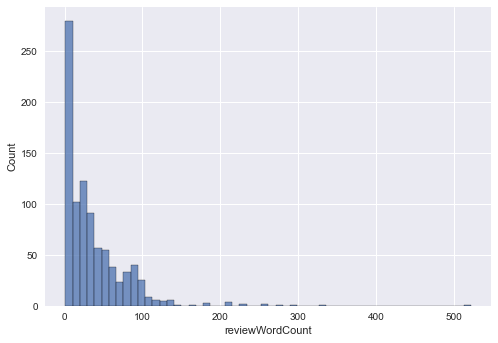

In [72]:
sns.histplot(df_main["reviewWordCount"])
plt.show()

We can see that most reviews are less than 50 words. The long tail in the distribution is caused by outliers. 

# (iv) Data pre-processing

## We'll be using mainly "review" column in order to cluster the reviews

### Clean "review" column from:
- "tweet-preprocessor" cleans the text from: emojis, smileys, hashtags etc
- Lower case the text
- Remove redundant spaces 

In [73]:
def clean_text(text):
    text = p.clean(text)
    text = text.lower() #Lower case the text
    return text.strip() # Remove additional spaces

In [74]:
#Clean "review" column, then put cleaned text to a new column ("reviewClean")
df_main = df_main.assign(reviewClean = df_main.review.apply(clean_text))

In [75]:
df_main.head()

,revPostDate,isEdited,title,review,rating,devResponse,devResponseDate,store,country,continent,durationUntilDevResponse,thumbsUpCount,reviewCreatedVersion,reviewWordCount,reviewClean
0,2021-04-25 12:17:31,NaN,NaN,I love the design of this app. It is visually ...,3,NaN,NaT,Google,NaN,NA,NaT,0.0,1.2.1,80,i love the design of this app. it is visually ...
1,2021-04-24 03:24:38,NaN,NaN,I sent one message and was informed that I had...,1,NaN,NaT,Google,NaN,NA,NaT,0.0,1.2.1,47,i sent one message and was informed that i had...
2,2021-04-23 22:05:12,NaN,NaN,"""Does this app make you happy?""",5,NaN,NaT,Google,NaN,NA,NaT,0.0,1.2.1,6,"""does this app make you happy?"""
3,2021-04-23 04:46:57,NaN,NaN,"Ok, the concept of this app is awesome, but is...",3,NaN,NaT,Google,NaN,NA,NaT,0.0,1.2.1,42,"ok, the concept of this app is awesome, but is..."
4,2021-04-23 02:24:40,NaN,NaN,Can't even try the app. Requires to validate w...,1,NaN,NaT,Google,NaN,NA,NaT,0.0,NaN,21,can't even try the app. requires to validate w...


### Word embedding with Spacy

We'll be using a large Spacy pipeline trained on the web from the following sources: blogs, news and comments.

<img src="../images/spacy_word_embedding.png">

In [76]:
nlp = spacy.load("en_core_web_lg") #Load English data, 742mb

In [77]:
#Example
test = nlp("hello world")
test.vector.shape #The result is a 300 dimensional vector representing "hello world"

(300,)

### Tokenization

<img src="../images/tokenization.png">

In [78]:
#Init NLP tokenizor
spacy_tokenizer = nlp.tokenizer
#Example
list(spacy_tokenizer("hello again world!"))

[hello, again, world, !]

### Lemmatization

Obtain the root of the words using lemmatization, resulting in as smaller and cleaner set

<img src="../images/lemmatization.png">

In [79]:
punctuations = string.punctuation
stopwords = list(STOP_WORDS)

In [80]:
#Implement lemmatization, remove stop words and punctuations
def tokenize(text):
    text = nlp(text)
    #Lemmatization
    text = [word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in text]
    #Remove stop words and punctuations
    text = [word for word in text if word not in stopwords and word not in punctuations]
    return text

In [81]:
#Example
tokenize("There's a nice weather outside (not too hot). A good time for a walk!")

['nice', 'weather', 'outside', 'hot', 'good', 'time', 'walk']

### Apply tokenization on "reviewClean"

In [82]:
tqdm.pandas() #This shows a smart progress bar so that we can keep track of the tokenization
df_main["reviewProcessed"] = df_main["reviewClean"].progress_apply(tokenize)

100%|███████████████████████████████████████████████████████████| 908/908 [00:08<00:00, 112.67it/s]


### Vectorization

Now we need to convert "reviewClean" into a format that can be handled by algorithms. We'll use tf-idf to convert the text and measure how important each word is to the instance out of the whole corpus

In [83]:
def vectorize(text):
    vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform(text)
    return X

In [84]:
#Clustering based off the content of the reviews
rev_text = df_main["reviewClean"].values
X = vectorize(rev_text)
X.shape

(908, 2932)

# (V) PCA and clustering  with KMeans

In order for KMeans to have an easier time cluestering the data, weneed to reduce the dimensions of the vectorized data. We'll be reducing the dimensions with PCA (Principle Component Analysis) while still keeping 95% variance. That is, we hope to remove some of the noise/outliers from the data yet still keep most of it.

**Note:**
- X_reduced is used for KMeans (data has been reduced with PCA)
- X is used for t-SNE (original data)

In [85]:
pca = PCA(n_components=0.95, random_state=42)
X_reduced = pca.fit_transform(X.toarray())
X_reduced.shape

(908, 607)

We'll run **KMeans** on the vectorized text. Then given the number of clusters k, KMeans will categorize each vector by calculating its mean distance to a randomly initialized centroid. The centroids are updated iteratively.

<img src="../images/kmeans.png">

### Optimal numer of clusters

We'll be using the **silhouette score** approach, which calculates the mean ***silhouette coefficient*** over all the instacnes.

An instances sillhouette coefficient is equal to $(a - b) \ max(a, b)$m where:
- $a$ is the mean distance to the other instances in the same cluster (_intra-cluster distance_)
- $b$ is the mean _nearest cluster distance_, that is the mean distance to the instances of the closest cluster (defined as the one minimizing $b$, excluding the instance's own cluster)

The silhouette coefficient can vary between +1 and -1:
- A coefficient close to +1 means that the instance is well inside its own cluster and far from other cluster
- A coefficient close to 0 means that it's close to a cluster boundary
- A coefficient close to -1 means that the instances may have been assigned to a wrong cluster 

In [180]:
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(X_reduced)
               for k in range(1, 20)]

In [182]:
#Centroids (labels) of each point
silhouette_scores = [silhouette_score(X_reduced, model.labels_)
                    for model in kmeans_per_k[1:]]

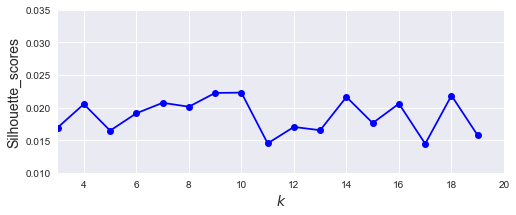

In [192]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 20), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette_scores", fontsize=14)
plt.axis([3, 20, 0.01, 0.035])
plt.show()

We can see from the plot that $k=9$ and $k=10$ are good choices. We'll use $k=10$. **Note**, we can see that the coefficients are close to 0, which means that they are close to a boundary

### Run KMeans

Initialize KMeans with chosen number of $k$ and insert to a new column

In [201]:
kmeans = KMeans(n_clusters=10, random_state=42)
y_pred = kmeans.fit_predict(X_reduced)
df_main["y"] = y_pred

# (vi) Dimensionality reduction with t-SNE

We'll use t-SNE to reduce X from a high dimensional feature vector to 2 dimensions. Then, we can use the 2 dimensions as x, y coordinates to plot the reviews

In [204]:
tsne = TSNE(verbose=1, random_state=42)
X_embedded = tsne.fit_transform(X.toarray())

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 908 samples in 0.004s...
[t-SNE] Computed neighbors for 908 samples in 0.064s...
[t-SNE] Computed conditional probabilities for sample 908 / 908
[t-SNE] Mean sigma: 0.258799
[t-SNE] KL divergence after 250 iterations with early exaggeration: 78.851990
[t-SNE] KL divergence after 1000 iterations: 1.883835


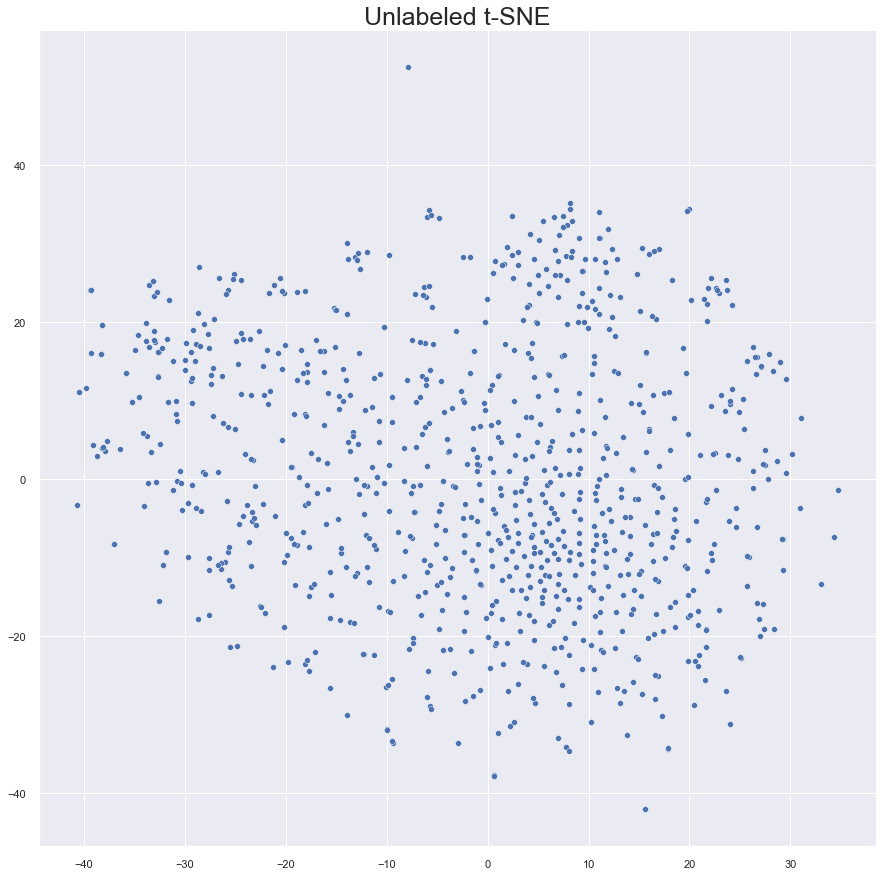

In [208]:
#Seaborn figsize setting
sns.set(rc={"figure.figsize":(15, 15)})

palette = sns.color_palette("bright", 1)

sns.scatterplot(x=X_embedded[:, 0], y=X_embedded[:, 1], palette=palette)
plt.title("Unlabeled t-SNE", fontsize=25)
plt.show()

We can see some clusters after reducing the dimensionality, yet we need labels. Thus, we'll be using the clusters found by k-means as labels. Ultimately, we'll be able to visually separate the clusters.

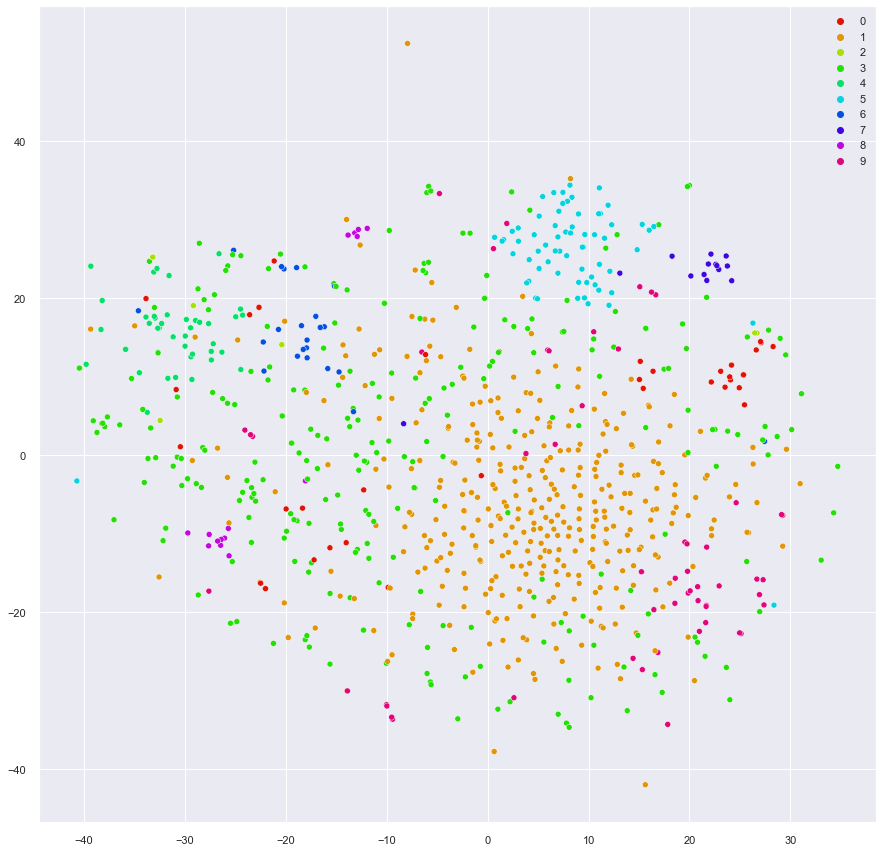

In [240]:
#Seaborn figsize setting
sns.set(rc={"figure.figsize":(15, 15)})

palette = sns.hls_palette(10, l=.45, s=0.95)#10=n_colors, l=lightness, s=saturation

sns.scatterplot(x=X_embedded[:, 0], y=X_embedded[:, 1], hue=y_pred, legend="full",
               palette=palette)
plt.show()